In [1]:
import pandas as pd
from matplotlib import style
import numpy as np
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import datetime
import talib
import scipy
from scipy.signal import argrelmax
from scipy.signal import argrelmin


In [2]:
def CryptoDataCSV(symbol, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df1 = pd.read_json(url)
    df1.set_index('date',inplace=True)
    df1.to_csv(symbol + '.csv')
    print('Processed: ' + symbol)
    
def CryptoData(symbol, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    return df

tickers = ['USDT_BTC','USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH',
 'USDT_XRP','USDT_LTC','USDT_STR','USDT_REP','USDT_ZEC']


for x in tickers:
    CryptoDataCSV(x,14400)

Processed: USDT_BTC
Processed: USDT_ETC
Processed: USDT_XMR
Processed: USDT_ETH
Processed: USDT_DASH
Processed: USDT_XRP
Processed: USDT_LTC
Processed: USDT_STR
Processed: USDT_REP
Processed: USDT_ZEC


In [3]:
tickers = ['USDT_BTC','USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH',
 'USDT_XRP','USDT_LTC','USDT_STR','USDT_REP','USDT_ZEC']


def retrieve_symbol_name(coin,window):
    col=['date','close']
    df=pd.read_csv(coin+'.csv',index_col='date')['close']
    df=pd.DataFrame(df)
    
    if coin in tickers:
        df.columns=[coin[5:]]
        df[coin[5:]+'_change']=df[coin[5:]].pct_change()
    df['RSI']=talib.RSI(df[coin[5:]], timeperiod=window)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    return df

def set_period(df,date): 
    df=df[df.index>date]
    return df

BTC=retrieve_symbol_name('USDT_BTC',14)


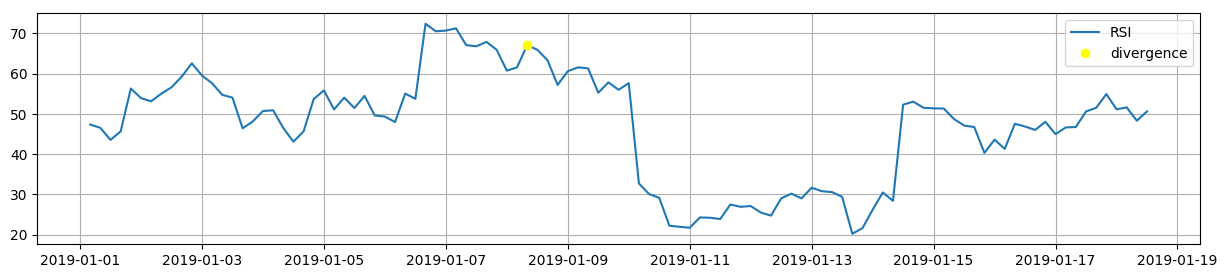

In [26]:
def divergence(coin,lookback,window,date,maxx):
    df=set_period(retrieve_symbol_name(coin,window),date)
    x=df['RSI'].values
    peaks=scipy.signal.argrelmax(x)
    peaks=peaks[0]
    prices=df[coin[5:]].iloc[peaks]
    duh=[]
    weak=[]
    lows=[]
    for x in peaks:    
        duh.append(x)
        
        if df['RSI'].iloc[x]>maxx:
            if df['RSI'].iloc[x]<max(df['RSI'].iloc[max(0,x-lookback):x]):
                weak.append(x)
        
        if df[coin[5:]].iloc[x]>max(df[coin[5:]].iloc[max(0,x-lookback):x]):
            lows.append(x)
            
    dt=set(lows)
    dt2=set(weak)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    dt = df.iloc[mergedlist].index.values         
    mergedlist=np.sort(mergedlist)
    return mergedlist
        

def plot_peaks(coin,lookback,window,date,maxx):
    df=set_period(retrieve_symbol_name(coin,window),date)
    div=divergence(coin,lookback,window,date,maxx)
    divv=df['RSI'].iloc[div]
    from pylab import rcParams
    plt.style.use("default")
    plt.figure(figsize=(15,3))
    x=df['RSI']
    x=x.values
    peaks=scipy.signal.argrelmax(x)
   
    plt.plot(df['RSI'],label='RSI')
    #plt.plot(z,'+',color='black',label='max')
    plt.plot(divv,'o',color='yellow',label='divergence')
    plt.legend(loc=1)
    plt.grid(True)
    plt.show()
    

plot_peaks('USDT_BTC',(7*4),14,'2019-01-01 00:00:00',50)

In [174]:
len(divergence('USDT_BTC',(7*6),14,'2018-02-22 00:00:00',50))

44

In [180]:
n=rise('USDT_BTC',(7*6),14,'2018-08-22 00:00:00',50)

In [27]:
def decline(coin, RSI_min, window,date):
    df=set_period(retrieve_symbol_name(coin,window),date)
    df_decline=df[df['RSI']<RSI_min]
    return df_decline

def rise(coin,lookback,window,date,maxx):
    df=set_period(retrieve_symbol_name(coin,window),date)
    div=divergence(coin,lookback,window,date,maxx)
    df_rise=df['RSI'].iloc[div]
    return df_rise

def dates_v2(date,df):
    list0=[]
    for i in df.index:
        list0.append(i-date)
    list0=pd.DataFrame(list0)
    list0.columns=['dates']
    list0=list0[list0>0]
    list0=list0.dropna()
    list0.sort_values(by=['dates'])
    return list0.iloc[0,:]


def time_diff(coin,RSI_min,maxx,lookback,window,date,direction):
    time=[]
    fall=decline(coin,RSI_min,window,date)
    ascent=rise(coin,lookback,window,date,maxx)
    zero=np.zeros(1,)
    if len(ascent)<1:
        ascent
    if direction=='long':
        if len(ascent)>0:
            fall=fall.ix[fall.index<ascent.index[-1]]
            for x in range (len(fall)):
                time.append(dates_v2(fall.index[x],ascent))
    else:
        if len(fall)>0:
            ascent=ascent.ix[ascent.index<fall.index[-1]]
            for i in range (len(ascent)):
                time.append(dates_v2(ascent.index[i],fall))
    return time

def retrieve_dates(event_dates,time_diff):
    dates=[]
    time=[]
    List=[dates,time]
    for x,y in zip(event_dates,time_diff):
        dates.append(x)
        time.append(y)
        
    List=pd.DataFrame(List)
    List=List.transpose()
    List.columns=['entry_date','time']
    new_time=[]
    for i in range(len(List)):
        new_time.append(List['time'][i][0])
    List['time_shift']=new_time
    List=List.drop(['time'],axis=1)
    exit=[]
    for x,y in zip(List['time_shift'],List['entry_date']):
        exit.append(x+y)
    List['exit_date']=exit
    List.index=List['entry_date']
    List=List.drop(['entry_date'],axis=1)
    return List

def back_test(coin,RSI_min,maxx,lookback,window,date,direction):
    if direction =='long':
        df=retrieve_dates(decline(coin,RSI_min,window,date).index, time_diff(coin,RSI_min,maxx,lookback,window,date,direction))
    else:
        df=retrieve_dates(rise(coin,RSI_min,window,date,maxx).index, time_diff(coin,RSI_min,maxx,lookback,window,date,direction))
    
    #if len(df) >0:
        #df=set_period(df,period)
    
    entry_price=[]
    for i in df.index:
        entry_price.append(retrieve_symbol_name(coin,window).loc[i][coin[5:]])
    exit_price=[]
    for x in df['exit_date']:
        exit_price.append(retrieve_symbol_name(coin,window).loc[x][coin[5:]])
    List=[entry_price,exit_price]
    List=pd.DataFrame(List)
    List=List.transpose()
    List.columns=['entry','exit']
    List.index=df.index
    List['returns']=(List['exit']/List['entry'])-1
    time_shift=[]
    for x in df['time_shift']:
        time_shift.append(x)
    List['duration']=time_shift
    
    if direction=='long':
        List['returns']=List['returns']
    else:
        List['returns']=List['returns']*-1
    
    List['cumulative_returns']=List['returns'].cumsum()
    return List

df=back_test('USDT_ETC',30,60,7*6,14,'2018-01-01 00:00:00','short')

In [44]:
def backtest_update(coin,RSI_min,maxx,lookback,window,date,direction):
    
    if direction =='long':
        df=retrieve_dates(decline(coin,RSI_min,window,date).index, time_diff(coin,RSI_min,maxx,lookback,window,date,direction))
    else:
        df=retrieve_dates(rise(coin,RSI_min,window,date,maxx).index, time_diff(coin,RSI_min,maxx,lookback,window,date,direction))
    
    
    if len(df) >0:
        df=set_period(df,date)
    pos=1
    capital=1000
    n=10
    entry_date=[]
    exit_date=[]
    time_shift=[]
    
    entry_price=[]
    exit_price=[]
    returns=[]
    cash=[capital]
    PnL=[]
    positions=[pos]
    early_dates=[]
    
    for index,row in df.iterrows():
        if 1==1:#cash[-1]>capital/n:
            entry_date.append(index)
            exit_date.append(row[1])
            time_shift.append(row[0])
            
            
            entry__price=retrieve_symbol_name(coin,window).loc[index][coin[5:]]
            exit__price=retrieve_symbol_name(coin,window).loc[row[1]][coin[5:]]
            ret=(exit__price/entry__price)-1
            
           
            profit=(capital/n)*ret
            if direction=='long':
                profit=profit
            else:
                profit=profit*-1
            
            
            if len(entry_date)>=2:
                if entry_date[-1]<exit_date[-2]:
                    early_dates.append(entry_date[-1])
                
            updated_cash=cash[-1]
                   
            
            if index in early_dates:
                updated_cash=updated_cash-capital/n
            else:
                updated_cash=updated_cash+profit
            
            
            if len(entry_date)>=2:
                if entry_date[-1]>exit_date[-2]:
                    pos=1
                else:
                    pos=pos+1
            
            if len(entry_date)>=2:
                if positions[-1]>=2:
                    if entry_date[-1]>exit_date[-2]:
                        updated_cash=updated_cash+(capital/n)*(positions[-1]-1)+sum(PnL[-positions[-1]+1:])
            
            
            positions.append(pos)
            entry_price.append(entry__price)
            exit_price.append(exit__price)
            returns.append(ret)
            PnL.append(profit)
            
            cash.append(updated_cash)
            
    cash=cash[1:len(cash)]
    positions=positions[1:len(positions)] 
    List=[entry_date,exit_date,entry_price,exit_price,time_shift,returns,cash,PnL]
    col= ['entry_date','exit_date','entry_price','exit_price','duration','returns','capital','PnL']
    List=pd.DataFrame(List)
    List=List.transpose()
    List.columns=col
    List.index=List['entry_date']
    List=List.drop(['entry_date'],axis=1)
    
    List['cumulative_PnL']=List['PnL'].cumsum()
    List['positions']=positions
   # List=List.dropna()
    if direction=='long':
        List['returns']=List['returns']
    else:
        List['returns']=List['returns']*-1
    
    trades=[]
    for x in range(len(List['exit_price'])):
        trades.append(len(List.exit_price[0:x].unique()))
    List['trades']=trades
    zero=np.zeros((1, 10))
    #zero[:10]=1
    #zero=pd.DataFrame(zero)
    #List=List.append(zero)
    if len(List)<1:
        List=pd.DataFrame(zero,columns=List.columns)
        
    return List
df1=backtest_update('USDT_BTC',20,60,7*6,14,'2018-01-01 00:00:00','short')
df1

KeyError: 'the label [2019-02-03 08:00:00] is not in the [index]'

In [42]:
def stats_v2(coin,RSI_min,maxx,lookback,window,date,direction):#requires backtest function
    df=backtest_update(coin,RSI_min,maxx,lookback,window,date,direction)
    Stats=pd.DataFrame()
    Stats[coin[5:]]=df['returns'].map(float).describe()
    Stats=Stats.transpose()
    Time_shift=[]
    for x in df['duration']:
        Time_shift.append(x)
    if Stats['count'][0]>1:
        Stats['Sharpe']=Stats['mean']/Stats['std'] 
        Time=pd.DataFrame(Time_shift)
        x=Time.mean()
        Stats['Average_time']=x[0]
        x=df[df['returns']>0]
        Stats['win%']=len(x)/len(df)
        Stats['trades']=df['trades'][-1]
    
    zero=np.zeros((1, 8))
    if len(Stats)<1:
        Stats['std']=0
        
        #Stats=pd.DataFrame(zero,columns=Stats.columns)
    #Stats['std']=0
    return Stats

coins=['USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH','USDT_XRP','USDT_LTC','USDT_STR','USDT_REP','USDT_ZEC']

def collective_stats(RSI_min,maxx,lookback,window,date,direction):
    stats=[]
    df=stats_v2('USDT_BTC',RSI_min,maxx,lookback,window,date,direction)
    
    for coin in coins:
        df=df.append(stats_v2(coin,RSI_min,maxx,lookback,window,date,direction))
    df=df.dropna()
    return df

stats_v2('USDT_BTC',30,60,7*6,14,'2018-01-01 00:00:00','short')

,count,mean,std,min,25%,50%,75%,max,Sharpe,Average_time,win%,trades
BTC,47.0,0.055057,0.086152,-0.142891,0.00995,0.059835,0.112472,0.296859,0.639072,10 days 08:10:12.765957,0.744681,26


In [12]:
df=retrieve_dates(rise('USDT_BTC',(7*6),14,'2018-06-22 00:00:00',70).index,time_diff('USDT_BTC',30,70,7*6,14,'2018-06-22 00:00:00','short'))
df

,time_shift,exit_date
entry_date,,
2018-07-03 04:00:00,7 days 04:00:00,2018-07-10 08:00:00
2018-07-19 20:00:00,11 days 16:00:00,2018-07-31 12:00:00
2018-07-20 08:00:00,11 days 04:00:00,2018-07-31 12:00:00
2018-07-23 04:00:00,8 days 08:00:00,2018-07-31 12:00:00
2018-07-24 08:00:00,7 days 04:00:00,2018-07-31 12:00:00
2018-07-24 20:00:00,6 days 16:00:00,2018-07-31 12:00:00
2018-09-01 16:00:00,4 days 00:00:00,2018-09-05 16:00:00
2018-12-20 20:00:00,20 days 16:00:00,2019-01-10 12:00:00


In [15]:
entry_price=[]
df
for i in df.index:
    entry_price.append(retrieve_symbol_name('USDT_BTC',14).loc[i]['BTC'])

In [16]:
entry_price

[BTC           6648.999999
 BTC_change       0.000105
 RSI             73.653946
 Name: 2018-07-03 04:00:00, dtype: float64, BTC           7475.188361
 BTC_change       0.003375
 RSI             77.883064
 Name: 2018-07-19 20:00:00, dtype: float64, BTC           7507.969444
 BTC_change       0.007558
 RSI             77.258091
 Name: 2018-07-20 08:00:00, dtype: float64, BTC           7752.100000
 BTC_change       0.016573
 RSI             71.791736
 Name: 2018-07-23 04:00:00, dtype: float64, BTC           8255.000000
 BTC_change       0.030379
 RSI             80.681757
 Name: 2018-07-24 08:00:00, dtype: float64, BTC           8410.000000
 BTC_change       0.018160
 RSI             80.143472
 Name: 2018-07-24 20:00:00, dtype: float64, BTC           7259.583736
 BTC_change       0.012469
 RSI             71.646792
 Name: 2018-09-01 16:00:00, dtype: float64, BTC           4050.654950
 BTC_change       0.010307
 RSI             78.033842
 Name: 2018-12-20 20:00:00, dtype: float64]

In [194]:
ascent=rise('USDT_BTC',(7*6),14,'2018-08-22 00:00:00',60)
ascent

date
2018-08-25 12:00:00    63.307300
2018-08-27 12:00:00    60.424953
2018-09-01 16:00:00    71.646792
2018-09-02 16:00:00    69.224569
2018-09-03 16:00:00    66.994653
2018-09-04 12:00:00    68.625978
2018-09-05 00:00:00    66.960351
2018-09-28 04:00:00    68.066051
2018-11-06 12:00:00    63.297709
2018-12-18 00:00:00    69.240944
2018-12-20 20:00:00    78.033842
2018-12-24 04:00:00    69.058192
2019-01-08 08:00:00    67.046048
Name: RSI, dtype: float64

In [191]:
fall=decline('USDT_BTC', 40, 14,'2018-08-22 00:00:00')
fall.head()

,BTC,BTC_change,RSI
date,,,
2018-09-05 08:00:00,6995.015559,-0.051832,33.932596
2018-09-05 12:00:00,6990.000000,-0.000717,33.699268
2018-09-05 16:00:00,6905.211000,-0.012130,29.949965
2018-09-05 20:00:00,6700.000000,-0.029718,23.217293
2018-09-06 00:00:00,6440.495721,-0.038732,17.775505


In [95]:
import statsmodels.tsa.stattools as ts

#test data for unit with Dickey Fuller test
def ADF_test(coin):
    ADF=ts.adfuller(retrieve_symbol_name(coin)[coin[len(coin)-3:]], 1)
    return ADF   
ADF_test('USDT_STR')                                  